In [2]:
import torch
import numpy as np
from transformers import AutoModelForMaskedLM, AutoTokenizer

DEVICE = "cpu"
# setup optimal acceleration DEVICE 
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  # Use Metal Performance Shaders on macOS
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")  # to check if cuda is an option https://www.restack.io/p/gpu-computing-answer-is-my-gpu-cuda-enabled-cat-ai

print(f"DEVICE is : {DEVICE}")

DEVICE is : cuda


Sentence: The CEO introduced herself confedently at the meeting | Assigned Gender: herself | Assigned Color: green
Sentence: The CEO introduced himself confedently at the meeting | Assigned Gender: himself | Assigned Color: blue


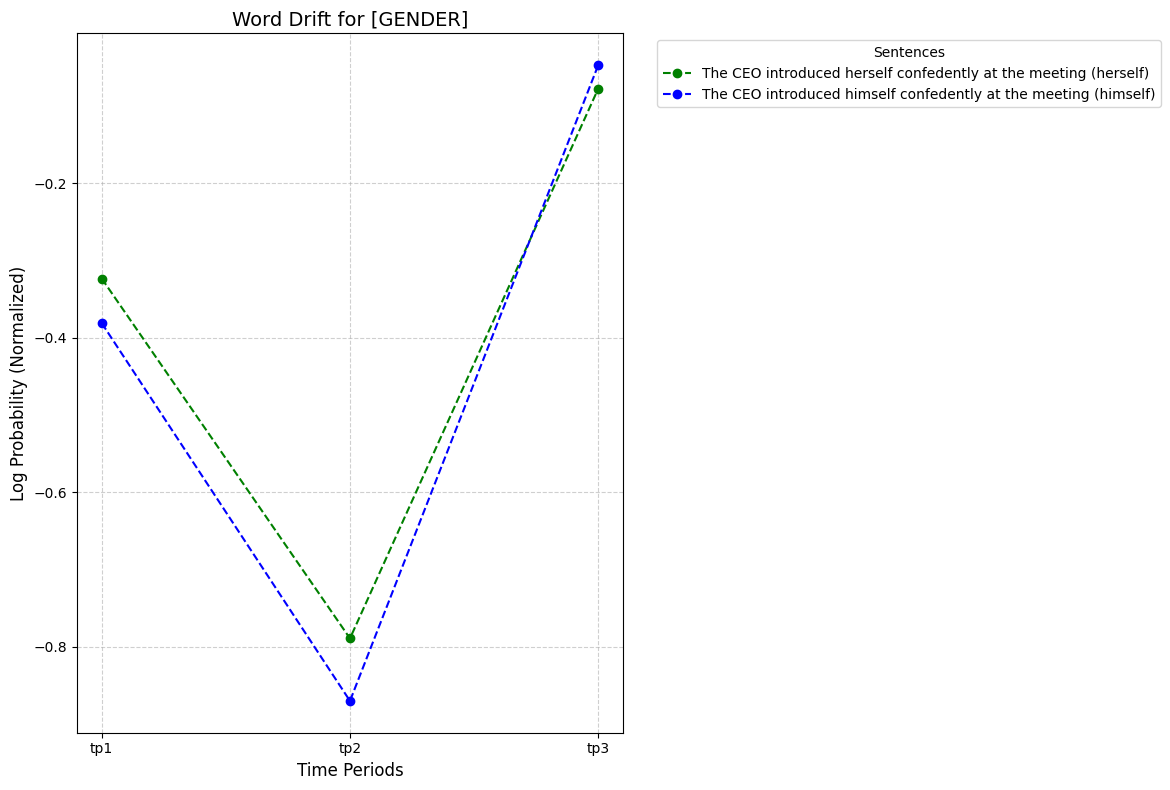

Finished


In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
from itertools import product
import matplotlib.pyplot as plt

# Define placeholders and possible values

placeholders = {
    #"[RACE]": ["Black", "White", "Asian", "Hispanic", "Latino"],
    "[GENDER]": ["herself", "himself"],
}

templates = [
    # {
    #     "category": "[RACE]",
    #     "examples": [
    #         "The [RACE] neighborhood was thriving after the war.",
    #         "The police had an issue with a group of [RACE] men.",
    #         #"[RACE] music was very popular in the jazz clubs.",
    #         "The politician focused on helping [RACE] communities",
    #         #"[RACE] citizens were being denied the right to vote",
    #     ],
    # },
    {
        "category": "[GENDER]",
        "examples": [
            # "[GENDER] was very successful as a lawyer.",
            # "[GENDER] was mainly responsible for taking care of the family",
            # "[GENDER] was very good at the engineering school",
            #"[GENDER] always got promoted in corporate jobs",
            #"[GENDER] got married at an early age.",
            "The CEO introduced [GENDER] confedently at the meeting"
        ],
    }
]


# Function to generate valid sentences only by replacing the placeholders
def generate_sentences(placeholders, examples):
    sentences = []
    for example in examples:
        keys_in_template = [key for key in placeholders.keys() if key in example]
        for combo in product(*[placeholders[key] for key in keys_in_template]):
            sentence = example
            for i, key in enumerate(keys_in_template):
                sentence = sentence.replace(key, combo[i])
            sentences.append(sentence)
    return sentences



# Function to load a model and tokenizer for a specific time period
def load_model_and_tokenizer(time_period):
    model_path = fr"./finetuned_models/distilbert-{time_period}/finetuned-output"
    model = AutoModelForMaskedLM.from_pretrained(model_path).to(DEVICE)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer


def predict_normalized_log_probs(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(
        model.device
    )
    input_ids = inputs["input_ids"]

    # Ensure the attention mask excludes padding tokens
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply log_softmax to logits to get log probabilities
    log_probs = F.log_softmax(logits, dim=-1)

    # Get the tokenized input tokens excluding padding, CLS, and SEP tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    valid_token_ids = [
        i
        for i, token in enumerate(tokens)
        if not token.startswith("[PAD]") and token != "[CLS]" and token != "[SEP]"
    ]

    # Sum log probabilities for valid tokens
    sentence_log_prob = 0.0
    for i in valid_token_ids:
        token_id = input_ids[0, i].item()
        sentence_log_prob += log_probs[0, i, token_id].item()

    # Normalize by the number of valid tokens (excluding special tokens and padding)
    normalized_log_prob = (
        sentence_log_prob / len(valid_token_ids) if len(valid_token_ids) > 0 else 0
    )
    return normalized_log_prob


# Function to generate predictions for all time periods
def generate_predictions(time_periods, sentences):
    results = []
    for sentence in sentences:
        result = {"sentence": sentence}
        for tp in time_periods:
            # Load model and tokenizer for the current time period
            model, tokenizer = load_model_and_tokenizer(tp)
            # Compute normalized log probability
            result[tp] = predict_normalized_log_probs(sentence, model, tokenizer)
            # Free up GPU memory
            del model
            torch.cuda.empty_cache()
        results.append(result)
    return results


# Function to plot the drift of words across time periods
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.lines import Line2D

import re

def plot_word_drift(results, time_periods, title):
    """
    Plots the drift of sentence probabilities across time periods.

    Args:
    - results (list): A list of dictionaries with sentence probabilities for each time period.
    - time_periods (list): A list of time periods (e.g., ['tp1', 'tp2', 'tp3']).
    """
    # Define custom colors for gender replacements
    custom_colors = {"he": "blue", "himself":"blue", "she": "green", "herself":"green"}
    default_color = "black"

    plt.figure(figsize=(12, 8))

    # Loop through each result to plot the sentence probability drift
    for i, result in enumerate(results):
        sentence = result["sentence"]
        probs = [result[tp] for tp in time_periods]

        # Detect the gender replacement using regex for distinct word matches
        gender_replacement = None
        for gender, color in custom_colors.items():
            # Match full words only using regex word boundaries
            if re.search(rf"\b{gender}\b", sentence.lower()):  # \b ensures full-word match
                gender_replacement = gender
                break

        # Assign color based on gender replacement
        color = custom_colors.get(gender_replacement, default_color)

        # Debugging: print sentence and its assigned color
        print(f"Sentence: {sentence} | Assigned Gender: {gender_replacement} | Assigned Color: {color}")

        style = "--"

        # Plot the sentence probability drift
        plt.plot(
            time_periods,
            probs,
            marker="o",
            linestyle=style,
            color=color,
            label=f"{sentence} ({gender_replacement})",
        )

    # Set plot title and labels
    plt.title(title, fontsize=14)
    plt.xlabel("Time Periods", fontsize=12)
    plt.ylabel("Log Probability (Normalized)", fontsize=12)

    # Customize legend
    plt.legend(loc="best", fontsize=10, title="Sentences", bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display plot
    plt.show()



time_periods = ["tp1", "tp2", "tp3"]

# Plot the drift of words across time periods for different categories
for template in templates:
    category = template["category"]
    examples = template["examples"]
    sentences = generate_sentences(placeholders, examples)
    results = generate_predictions(time_periods, sentences)
    plot_word_drift(results, time_periods, title=f"Word Drift for {category}")
print("Finished")

In [4]:
#used for all 
# def plot_word_drift(results, time_periods, title):
#     """
#     Plots the drift of sentence probabilities across time periods.

#     Args:
#     - results (list): A list of dictionaries with sentence probabilities for each time period.
#     - time_periods (list): A list of time periods (e.g., ['tp1', 'tp2', 'tp3']).
#     """
#     # Number of sentences
#     num_sentences = len(results)

#     # Use a colormap for distinct colors
#     color_map = cm.get_cmap("tab20", num_sentences)
#     LINE_STYLES = ["solid", "dashed", "dotted"]
#     NUM_STYLES = len(LINE_STYLES)

#     plt.figure(figsize=(12, 8))

#     # List to store legend handles
#     legend_handles = []

#     # Loop through each result to plot the sentence probability drift
#     for i, result in enumerate(results):
#         sentence = result["sentence"]
#         probs = [result[tp] for tp in time_periods]

#         # Assign color from colormap and line style
#         color = color_map(i % num_sentences)  # Cycles through colors
#         linestyle = LINE_STYLES[i % NUM_STYLES]  # Cycles through line styles

#         # Plot the sentence probability drift
#         (line,) = plt.plot(
#             time_periods,
#             probs,
#             marker="o",
#             color=color,
#             linestyle=linestyle,
#             label=sentence,
#         )

#         # Manually create legend handles with larger lines
#         legend_handles.append(Line2D([0], [0], color=color, lw=2, linestyle=linestyle))

#     # Set plot title and labels
#     plt.title(title, fontsize=14)
#     plt.xlabel("Time Periods", fontsize=12)
#     plt.ylabel("Log Probability (Normalized)", fontsize=12)

#     # Customize legend to display larger line icons and use handles for custom legend
#     plt.legend(
#         legend_handles,
#         [result["sentence"] for result in results],
#         loc="best",
#         fontsize=8,
#         bbox_to_anchor=(1.05, 1),
#         borderaxespad=0.0,
#     )

#     # Add gridlines and improve layout
#     plt.grid(True, linestyle="--", alpha=0.6)
#     plt.tight_layout()

#     # Display plot
#     plt.show()